# 03. Modeling

Notebook này sẽ sử dụng các hàm từ `src/models.py` để xây dựng và đánh giá mô hình.


In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from models import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)


## 1. Load dữ liệu đã preprocess


In [2]:
# Load dữ liệu đã preprocess (đã stratified split 80/20)
X_train = np.load('../data/processed/X_train.npy')
y_train = np.load('../data/processed/y_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

print("=" * 60)
print("LOAD DỮ LIỆU ĐÃ PREPROCESS")
print("=" * 60)
print("\nTrain set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Phân phối y_train: {np.bincount(y_train)}")
print(f"  Tỷ lệ class 1: {np.mean(y_train)*100:.2f}%")

print("\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Phân phối y_test: {np.bincount(y_test)}")
print(f"  Tỷ lệ class 1: {np.mean(y_test)*100:.2f}%")
print("=" * 60)

LOAD DỮ LIỆU ĐÃ PREPROCESS

Train set:
  X_train shape: (15327, 31)
  y_train shape: (15327,)
  Phân phối y_train: [11505  3822]
  Tỷ lệ class 1: 24.94%

Test set:
  X_test shape: (3831, 31)
  y_test shape: (3831,)
  Phân phối y_test: [2876  955]
  Tỷ lệ class 1: 24.93%


## 2. Dữ liệu đã được chia sẵn

- Dữ liệu ban đầu: toàn bộ `aug_train.csv` đã được tiền xử lý.
- Đã thực hiện **stratified split 80/20** để tạo ra `Train` và `Test` (giữ nguyên tỷ lệ class).
- Cả hai tập đều có nhãn (`y_train`, `y_test`) để đánh giá mô hình một cách chuẩn.

Sau khi train, ta sẽ đánh giá trực tiếp trên `Test set` và báo cáo Accuracy, Precision, Recall, F1.

In [3]:
# Thông tin kích thước sau stratified split
print("Dữ liệu sau stratified split 80/20:")
print(f"  - Train: {X_train.shape[0]:,} mẫu")
print(f"  - Test : {X_test.shape[0]:,} mẫu")

Dữ liệu sau stratified split 80/20:
  - Train: 15,327 mẫu
  - Test : 3,831 mẫu


## 3. Logistic Regression từ đầu


In [4]:
class LogisticRegression:
    """
    Logistic Regression từ đầu bằng numpy
    """
    
    def __init__(self, learning_rate=0.01, max_iters=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.tol = tol
        self.weights = None
        self.history = {'loss': [], 'accuracy': []}
    
    def sigmoid(self, z):
        # Clip z để tránh overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def predict_proba(self, X):
        z = X @ self.weights
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)
    
    def binary_cross_entropy(self, y_true, y_pred_proba):
        # Tránh log(0)
        epsilon = 1e-15
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        
        n = len(y_true)
        loss = -(1/n) * np.sum(
            y_true * np.log(y_pred_proba) + 
            (1 - y_true) * np.log(1 - y_pred_proba)
        )
        return loss
    
    def fit(self, X, y, verbose=True):
        n_samples, n_features = X.shape
        
        # Khởi tạo weights (bias đã được thêm vào X)
        self.weights = np.random.randn(n_features) * 0.01
        
        prev_loss = float('inf')
        
        for i in range(self.max_iters):
            # Forward pass
            z = X @ self.weights
            y_pred_proba = self.sigmoid(z)
            
            # Tính loss
            loss = self.binary_cross_entropy(y, y_pred_proba)
            
            # Backward pass - Gradient
            gradient = (1/n_samples) * X.T @ (y_pred_proba - y)
            
            # Update weights
            self.weights -= self.learning_rate * gradient
            
            # Lưu history
            y_pred = (y_pred_proba >= 0.5).astype(int)
            accuracy = accuracy_score(y, y_pred)
            self.history['loss'].append(loss)
            self.history['accuracy'].append(accuracy)
            
            # Check convergence
            if abs(prev_loss - loss) < self.tol * prev_loss:
                if verbose:
                    print(f"Converged at iteration {i+1}")
                break
            
            prev_loss = loss
            
            # Print progress
            if verbose and (i + 1) % 100 == 0:
                print(f"Iteration {i+1}/{self.max_iters}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        if verbose:
            print(f"Training completed. Final loss: {loss:.4f}, Final accuracy: {accuracy:.4f}")


### 3.1. Train mô hình

In [9]:
# Train Logistic Regression
lr_model = LogisticRegression(learning_rate=0.01, max_iters=500, tol=1e-6)
lr_model.fit(X_train, y_train, verbose=True)


Iteration 100/500, Loss: 0.6031, Accuracy: 0.7462
Iteration 200/500, Loss: 0.5634, Accuracy: 0.7657
Iteration 300/500, Loss: 0.5397, Accuracy: 0.7725
Iteration 400/500, Loss: 0.5245, Accuracy: 0.7741
Iteration 500/500, Loss: 0.5145, Accuracy: 0.7750
Training completed. Final loss: 0.5145, Final accuracy: 0.7750


### 3.2. Vẽ learning curve


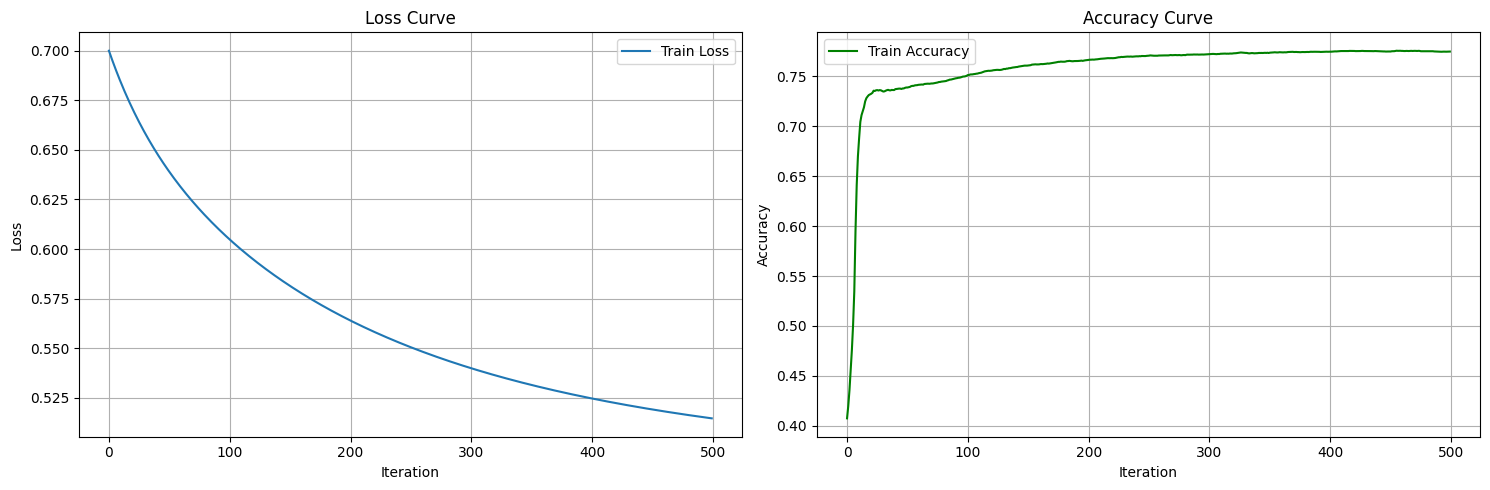

In [6]:
# Vẽ learning curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(lr_model.history['loss'], label='Train Loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curve
ax2.plot(lr_model.history['accuracy'], label='Train Accuracy', color='green')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curve')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### 3.3. Đánh giá trên Test set


In [7]:
# Dự đoán trên test set có nhãn
y_pred_test = lr_model.predict(X_test)
y_pred_proba_test = lr_model.predict_proba(X_test)

# Dự đoán trên train để tham khảo
y_pred_train = lr_model.predict(X_train)

print("=" * 60)
print("LOGISTIC REGRESSION - TEST SET EVALUATION")
print("=" * 60)
print(f"Số mẫu test: {len(y_test):,}")
print(f"Phân phối y_test: {np.bincount(y_test)} (Class 1: {np.mean(y_test)*100:.2f}%)")
print(f"Số mẫu dự đoán class 1: {np.sum(y_pred_test == 1):,} ({np.mean(y_pred_test == 1)*100:.2f}%)")
print(f"Số mẫu dự đoán class 0: {np.sum(y_pred_test == 0):,} ({np.mean(y_pred_test == 0)*100:.2f}%)")
print(f"\nXác suất trung bình của class 1 (test): {np.mean(y_pred_proba_test):.4f}")

print("\n" + "=" * 60)
print("METRICS TRÊN TEST SET")
print("=" * 60)
print(f"Accuracy : {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_test):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_test):.4f}")

LOGISTIC REGRESSION - TEST SET EVALUATION
Số mẫu test: 3,831
Phân phối y_test: [2876  955] (Class 1: 24.93%)
Số mẫu dự đoán class 1: 715 (18.66%)
Số mẫu dự đoán class 0: 3,116 (81.34%)

Xác suất trung bình của class 1 (test): 0.3348

METRICS TRÊN TEST SET
Accuracy : 0.7734
Precision: 0.5608
Recall   : 0.4199
F1 Score : 0.4802


## 5. Tổng kết kết quả


In [8]:
# Tổng kết kết quả
print("=" * 60)
print("TỔNG KẾT KẾT QUẢ")
print("=" * 60)

print("1. Train set:")
print(f"   - Số mẫu: {X_train.shape[0]:,}")
print(f"   - Số features: {X_train.shape[1]}")
print(f"   - Phân phối target: {np.bincount(y_train)}")
print(f"   - Tỷ lệ class 1: {np.mean(y_train)*100:.2f}%")
print(f"   - Train Accuracy : {accuracy_score(y_train, y_pred_train):.4f}")
print(f"   - Train Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"   - Train Recall   : {recall_score(y_train, y_pred_train):.4f}")
print(f"   - Train F1 Score : {f1_score(y_train, y_pred_train):.4f}")

print("\n2. Test set:")
print(f"   - Số mẫu: {X_test.shape[0]:,}")
print(f"   - Số features: {X_test.shape[1]}")
print(f"   - Phân phối target: {np.bincount(y_test)}")
print(f"   - Tỷ lệ class 1: {np.mean(y_test)*100:.2f}%")
print(f"   - Test Accuracy : {accuracy_score(y_test, y_pred_test):.4f}")
print(f"   - Test Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"   - Test Recall   : {recall_score(y_test, y_pred_test):.4f}")
print(f"   - Test F1 Score : {f1_score(y_test, y_pred_test):.4f}")

print("\n" + "=" * 60)

TỔNG KẾT KẾT QUẢ
1. Train set:
   - Số mẫu: 15,327
   - Số features: 31
   - Phân phối target: [11505  3822]
   - Tỷ lệ class 1: 24.94%
   - Train Accuracy : 0.7750
   - Train Precision: 0.5692
   - Train Recall   : 0.4024
   - Train F1 Score : 0.4715

2. Test set:
   - Số mẫu: 3,831
   - Số features: 31
   - Phân phối target: [2876  955]
   - Tỷ lệ class 1: 24.93%
   - Test Accuracy : 0.7734
   - Test Precision: 0.5608
   - Test Recall   : 0.4199
   - Test F1 Score : 0.4802

